<a href="https://colab.research.google.com/github/Aravind-98/Summer_Internship_2020/blob/master/Index_Tracker_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))   

Saving Price_All.csv to Price_All.csv
User uploaded file "Price_All.csv" with length 1527571 bytes


In [ ]:
pip install PyPortfolioOpt

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, SimpleRNN, GRU, Dense, RepeatVector, TimeDistributed
from keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import seaborn as sns
import cvxopt as opt
from cvxopt import blas,solvers
solvers.options['show_progress'] = False
pd.set_option('mode.chained_assignment', None)
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.optimize import nnls

In [ ]:
def load_data(filename):
    df=pd.read_csv(filename)
    df.dropna(inplace=True)
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    df=df[df.columns[1:]]
    return df

def get_data(df,type="Close"):
    '''
    The function get_data takes in a data frame and the financial metric like 'log returns'/'net_chg'/'percantage_chg'/'Close' computed on df.  
    '''
    if type == "log_returns":
        return pd.DataFrame(np.log(df/df.shift(1)).dropna())
    elif type == "net_change":    
        return pd.DataFrame(df-df.shift(1)).dropna()
    elif type == "percentage_change":
        return df.pct_change(1).dropna()
    else:
        return df

def scale_data(df,scaler_type="Min_Max"):
    '''
        returns the scaler and the dataframe of the scaled data
    '''
    if scaler_type == "Standard":
        scaler=StandardScaler()
        return scaler,scaler.fit_transform(df)
    else:
        scaler=MinMaxScaler()
        return scaler,scaler.fit_transform(df)  

# The AutoEncoder model built using a feed forward Deep Neural Net
def Deep_AutoEncoder(Data,compression=10):
    model= Sequential()
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(compression, activation='relu',name='Encoded'))
    model.add(Dense(Data.shape[1], activation='relu',name='Decoded',kernel_regularizer='l2'))
    model.compile(optimizer='rmsprop', loss='mse')
    hist=model.fit(Data,Data,epochs=800,batch_size=50,verbose=False,callbacks=[EarlyStopping(monitor='loss',patience=20,restore_best_weights=True)])

    model=Model(inputs=model.inputs, outputs=model.layers[2].output)
    decoded_data=model.predict(Data)
    return hist,model,decoded_data      

def LSTM_AutoEnc_1(Data,compression=10):
    # assume that at this point we have scaled data
    Data=np.reshape(Data,(1,Data.shape[0],Data.shape[1])) #(1 training example with 2441 timesteps and 46 features)
    model = Sequential()
    model.add(LSTM(compression, activation='relu', input_shape=(Data.shape[1],Data.shape[2]),return_sequences=True,name='Enc_1'))
    #model.add(SimpleRNN(20, activation='relu', return_sequences=True,name='Enc_1_1'))
    #model.add(SimpleRNN(Data.shape[2], activation='relu', return_sequences=True,name='Dec_1'))
    model.add(TimeDistributed(Dense(Data.shape[2],kernel_regularizer='l2'),name='dec_1'))
    model.compile(optimizer='rmsprop', loss='mse')
    
    hist=model.fit(Data,Data,epochs=1000,batch_size=1,verbose=False,callbacks=[EarlyStopping(monitor='loss',patience=20,restore_best_weights=True)])

    model=Model(inputs=model.inputs, outputs=model.layers[1].output)
    
    decoded_data=model.predict(Data)
    decoded_data=np.reshape(decoded_data,(decoded_data.shape[1],decoded_data.shape[2]))

    return hist,model,decoded_data     

def get_indices(Data, decoded_data, scaler):
    d_1=scaler.inverse_transform(Data)
    d_2=scaler.inverse_transform(decoded_data)
    rep_data=d_2-d_1
    sim=np.linalg.norm(rep_data,axis=0,ord=2)
    
    ind=np.argsort(sim)
    #print(str(ind))
    #print(str(sim[ind]))
    return ind,sim

def plot_denoised(df,Data,decoded_data,scaler, ind):
    d_1=scaler.inverse_transform(Data)
    d_2=scaler.inverse_transform(decoded_data)
    index=df.index[:Data.shape[0]]
    
    plt.figure(figsize=(10,5))
    plt.plot(index,d_2[:,ind[[0]]],'black',label='Denoised')
    plt.plot(index,d_1[:,ind[[0]]],'gold',label='Original')
    plt.title("Least Noisy Stock",loc='center')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(index,d_2[:,ind[[-1]]],'black',label='Denoised')
    plt.plot(index,d_1[:,ind[[-1]]],'gold',label='Original')
    plt.title("Most Noisy Stock",loc='center')
    plt.legend()
    plt.show()

def denoising_model(data,Model_type='LSTM',type='Close',compression=10):    
    scaler,data=scale_data(data,scaler_type="Min_Max")
    if Model_type=="LSTM":
        hist,model,decoded_data=LSTM_AutoEnc_1(data,10)
    else:
        hist,model,decoded_data=Deep_AutoEncoder(data,5)

    plot_model(model,show_shapes=True,show_layer_names=True)
    
    ind,_=get_indices(data, decoded_data, scaler)  
    #plot_denoised(df, data, decoded_data, scaler, ind)
    return ind      

def Normalize_Data(df,factor=100):
    df.iloc[0:]=df.iloc[0:]/df.iloc[0]*factor
    return df    

def Markowitz(data):
    mu=expected_returns.mean_historical_return(data)
    S=risk_models.sample_cov(data)
    ef=EfficientFrontier(mu,S)
    weights=ef.max_sharpe()
    cleaned_weights=ef.clean_weights()
    print(cleaned_weights)
    wt=[]
    for x in data.columns:
        wt.append(cleaned_weights.get(x))
    wt=np.array(wt)
    return wt

def get_portfolio_allocation(trainX, trainY,weight_type="Equal"):
    if weight_type=="Equal":
        leverage_factor=1
        weights=np.ones(len(trainX.columns),dtype=int)*(1/(len(trainX.columns)))
        weights = dict(zip(trainX.columns, weights))
        print("Equal")
    else:
        result = nnls(trainX, trainY)
        leverage_factor = sum(result[0])
        weights = result[0] / leverage_factor
        weights = dict(zip(trainX.columns, weights))
    
        #s1 = str(round(leverage_factor,5))+"("
        #for component in weights.keys():
            #s1 += str(round(weights[component],5))+'*'+component+" + "
        #s1 = s1[:-3]+")"
    
        #print("\nPortfolio Allocation:")
        #allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
        #allocation.set_index('Component',inplace=True)
        #allocation.plot.pie(y='Weight(%)',legend=None)
        #allocation.reset_index(inplace=True)
        #display(allocation)
    
        #print('\nPortfolio Simulated Close = ')
        #print(s1)
        #print("\nLeverage Factor:", leverage_factor)
        print("NNLS")
    return leverage_factor, weights
    
        

In [ ]:
def Markowitz_1(returns):
    returns=returns.pct_change(1).dropna()
    returns=np.array(returns).T
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt)


In [ ]:
def tracker(h,l,rebal_days,trn_prd,denoise_type='log_returns',compression=5,weight_type="Equal"):    
    df=load_data("Price_All.csv")
    dates=[df.index[trn_prd],]
    tracking_error=[]
    trans_cost=[]
    avg_trn=[]
    index=[100,]
    tracker_1=[100-(0.18+0.02*(h+l))]
    iter=int((2440-rebal_days-trn_prd)/rebal_days)
    for t in range(iter):
        #####################################
        st_train=rebal_days*t
        end_train=rebal_days*t+trn_prd
        st_test=end_train
        end_test=st_test+rebal_days

        dates.append(df.index[end_test])
        train_data=df[df.columns[:-1]].iloc[st_train:end_train]
        ind=denoising_model(train_data,"Deep",denoise_type,compression)
        chosen_indices=np.concatenate((ind[:h],ind[-l:]),axis=None)
        portfolio=df.columns[chosen_indices]
        port_pre=set(chosen_indices)
        ########### We have used the data in the training phase and have obtained our constituent stocks #####################

        normalized_test_data=Normalize_Data(df.iloc[st_test:end_test])    

        print("Iteration:"+str(t+1))#+'\n'+ str(list(portfolio)))

        norm_train=Normalize_Data(df.iloc[st_train:end_train])
        norm_train_x=norm_train[portfolio]
        norm_train_y=norm_train["Price_51"]
        
        test_data=normalized_test_data[portfolio]
        benchmark_test_data=normalized_test_data[normalized_test_data.columns[-1]]
        
        leverage,weights=get_portfolio_allocation(norm_train_x, norm_train_y,weight_type)
        tracker=leverage*test_data.dot(list(weights.values()))
        ##################### we have obatained tracker values for the testing phase, now we get tracking error ##################
        y=(index[-1]*benchmark_test_data.iloc[-1])/100
        index.append(y) 

        tracking_error.append(tracker[-1]-normalized_test_data[normalized_test_data.columns[-1]].iloc[-1])

        ####### halwa: the normailized values of the stocks in our portfolio at the end of the rebalancing ##############
        halwa=normalized_test_data[portfolio].iloc[-1]

        st_train_1=rebal_days*(t+1)
        end_train_1=rebal_days*(t+1)+trn_prd
        train_data=df[df.columns[:-1]].iloc[st_train_1:end_train_1]
        ind=denoising_model(train_data,"Deep",denoise_type,compression)
        port_post=set(np.concatenate((ind[:h],ind[-l:]),axis=None))
    
        replaced_stocks=normalized_test_data.columns[list(port_pre.difference(port_post))]
        replace_percent=halwa[replaced_stocks]
        replace_pct_chg=replace_percent-100
        sum_list=[]
        if len(replaced_stocks)==0:
            transaction_cost=0.0018*np.mean(abs(halwa-tracker[-1]))+0.02*(h+l)
            trans_cost.append(transaction_cost)
            avg_trn.append(0)
        else:
            for i in range(len(replaced_stocks)):
                sum_list.append(min(replace_pct_chg.iloc[i],tracker[-1]-100))
            transaction_cost=0.0018*np.mean(abs(halwa-tracker[-1]))+2*0.0018*(100*len(replaced_stocks)+sum(sum_list))/h + 2*0.02*len(replaced_stocks) + 0.02*(h+l-len(replaced_stocks)) 
            trans_cost.append(transaction_cost)
            avg_trn.append(len(sum_list)/(h+l))
        x=tracker_1[-1]*(tracker[-1]/100)
        xy=x*(1-(transaction_cost/100))                    
        tracker_1.append(xy)
    
    tracking_error=np.array(tracking_error)
    a=sum((tracking_error<=1) & (tracking_error>=-1))/(iter+1)
    b=sum((tracking_error>=4) & (tracking_error<=-4))/(iter+1)
    c=sum((tracking_error>0))/sum((tracking_error<0))
    trans_cost.insert(0,0.18+0.02*(h+l))
    rebal_cost=np.mean(trans_cost)                   
    aver_trn=np.mean(avg_trn)
    track_error=np.std(tracking_error)
    result={"dates":dates,
            "tracking error":track_error,
            "transaction cost":trans_cost,
            "average turnover":aver_trn,
            "index":index,
            "tracker":tracker_1,
            "1%":a,
            "4%":b,
            "OU ratio":c,
            "rebalance cost":rebal_cost
            }   

    return result


In [ ]:
result=tracker(5,10,40,480,denoise_type='log_returns',compression=5,weight_type="nnls")

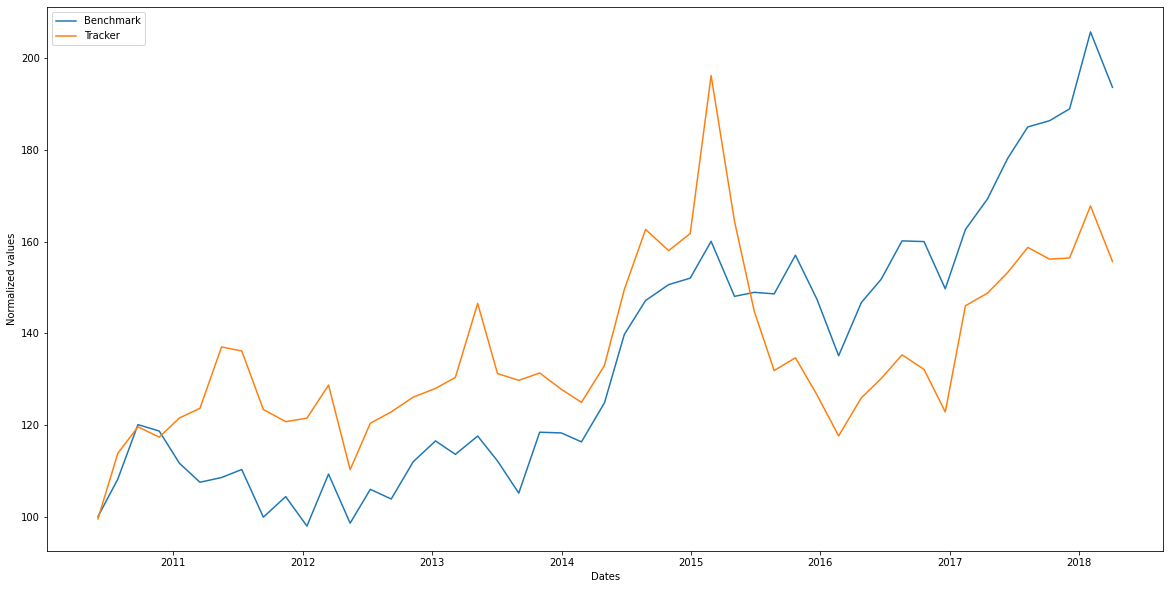

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(result['dates'],result["index"],label="Benchmark")
plt.plot(result['dates'],result["tracker"],label="Tracker")
plt.xlabel("Dates")
plt.ylabel("Normalized values")
plt.legend()

In [ ]:
result=tracker(5,15,40,480,denoise_type='log_returns',compression=5,weight_type="nnls")

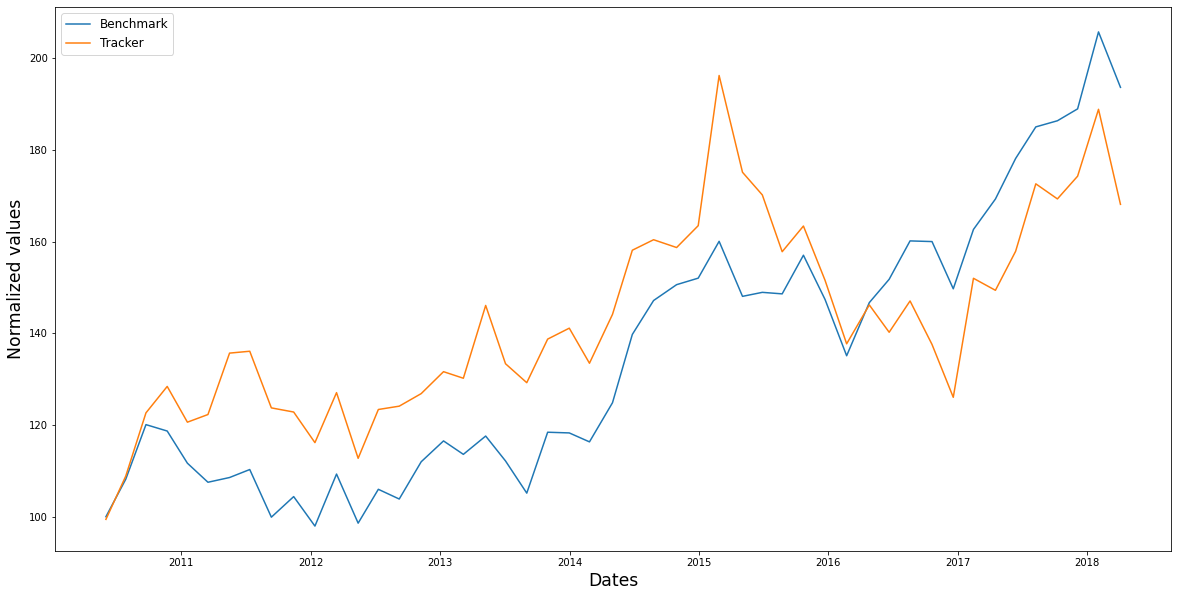

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(result['dates'],result["index"],label="Benchmark")
plt.plot(result['dates'],result["tracker"],label="Tracker")
plt.xlabel("Dates",fontsize='xx-large')
plt.ylabel("Normalized values",fontsize='xx-large')
plt.legend(fontsize='large')

In [ ]:
result_equal=tracker(5,15,40,480,denoise_type='log_returns',compression=5,weight_type="Equal")

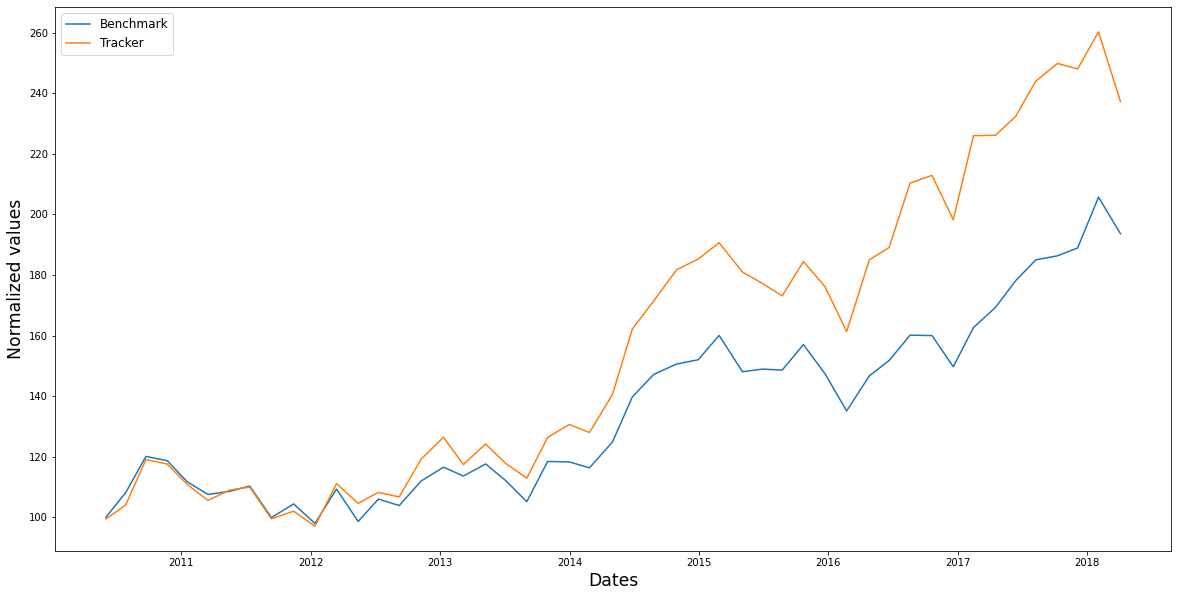

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(result_equal['dates'],result_equal["index"],label="Benchmark")
plt.plot(result_equal['dates'],result_equal["tracker"],label="Tracker")
plt.xlabel("Dates",fontsize='xx-large')
plt.ylabel("Normalized values",fontsize='xx-large')
plt.legend(fontsize='large')

In [ ]:
result.keys()

dict_keys(['dates', 'tracking error', 'transaction cost', 'average turnover', 'index', 'tracker', '1%', '4%', 'OU ratio', 'rebalance cost'])

In [ ]:
print("-"*70)
print("\t NNLS weighting")
print(" *********** Report ***************** ")
print('tracking error= '+str(result['tracking error']))
#print('transaction cost= '+str(np.mean(result['transaction cost'])))
print('average turnover= '+str(result['average turnover']))
print('1%= '+str(result["1%"]))
print('4%= '+str(result['4%']))
print('OU ratio= '+str(result["OU ratio"]))
print('rebalancing cost= '+str(result['rebalance cost']))
print("-"*70)

print("\n")


print("-"*70)
print("\t Equal weighting")
print(" *********** Report ***************** ")
print('tracking error= '+str(result_equal['tracking error']))
#print('transaction cost= '+str(np.mean(result_equal['transaction cost'])))
print('average turnover= '+str(result_equal['average turnover']))
print('1%= '+str(result_equal["1%"]))
print('4%= '+str(result_equal['4%']))
print('OU ratio= '+str(result_equal["OU ratio"]))
print('rebalancing cost= '+str(result_equal['rebalance cost']))
print("-"*70)

----------------------------------------------------------------------
	 NNLS weighting
 *********** Report ***************** 
tracking error= 4.718644237904885
average turnover= 0.3208333333333333
1%= 0.20408163265306123
4%= 0.0
OU ratio= 1.0869565217391304
rebalancing cost= 0.987615137822091
----------------------------------------------------------------------


----------------------------------------------------------------------
	 Equal weighting
 *********** Report ***************** 
tracking error= 2.6869445435444494
average turnover= 0.31354166666666666
1%= 0.24489795918367346
4%= 0.0
OU ratio= 2.6923076923076925
rebalancing cost= 0.9787051026472241
----------------------------------------------------------------------


Divyashish's values for a (15,10) split 


```
track error=2.33
aver_trn=0.34
1%=0.43
4%=0.1
OU ratio:1.72
rebal_cost=0.88
```


In [ ]:
def visualize_port_corr(h,l,returns=False):
    df=load_data("Price_All.csv")
    train_data=df[df.columns[:-1]].iloc[0:480]
    ind=denoising_model(train_data,"Deep")
    portfolio=np.concatenate((ind[:h],ind[-l:]),axis=None)
    
    X=df[df.columns[portfolio]]
    
    if returns==True:
        X=X.pct_change(1)
    corr=X.corr()
    plt.figure(figsize=(10,10))
    sns.heatmap(corr,annot=True) 

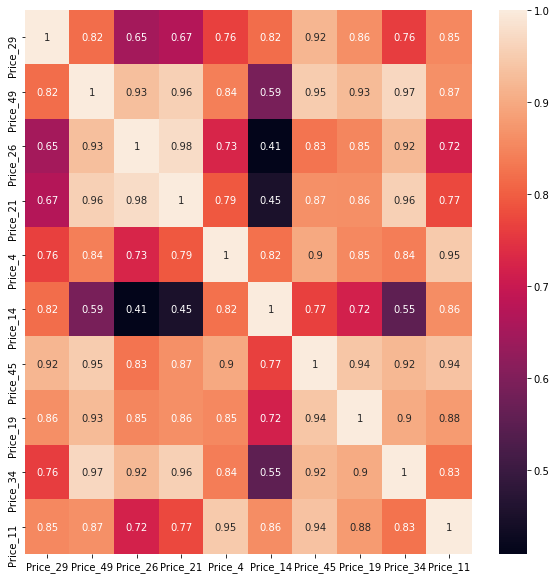

In [ ]:
visualize_port_corr(5,5)    

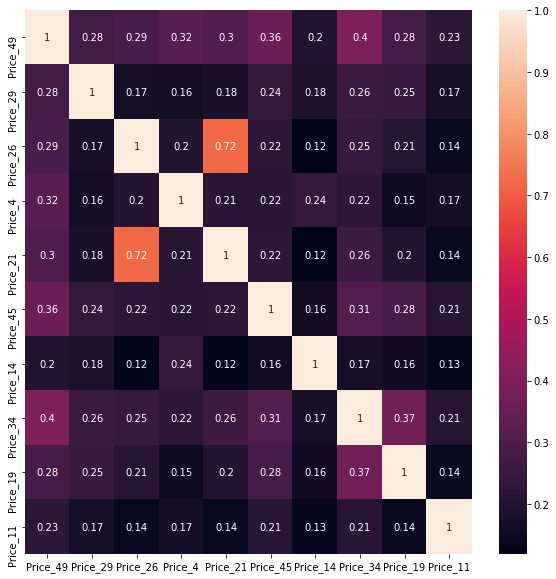

In [ ]:
visualize_port_corr(5,5,returns=True)    

In [ ]:
'''
def get_Tracker_input(df,ind,h,l):
    chosen_idx=np.concatenate((ind[:h],ind[-l:]),axis=None)+1
    
    X=df[df.columns[chosen_idx]] 
    X=scaler.fit_transform(X)

    Y=df["Price_51"]
    Y=np.asarray(Y)
    Y=Y.reshape((Y.shape[0],1))
    Y=scaler.fit_transform(Y)
    X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.30,shuffle=False)
    return X_train, X_test, y_train, y_test
'''

https://roamanalytics.com/2016/11/28/shape-matching-with-time-series-data/


The following portion uses the LSTM based architecture to predict the performance of the tracker

In [ ]:
df=load_data("Price_All.csv")
#scaler=MinMaxScaler()
#data=scaler.fit_transform(df)
#df=pd.DataFrame(data,columns=df.columns)
data=df[df.columns[:-1]]
data
returns=data.pct_change(1).dropna()
cov=returns.cov()*252

mu=expected_returns.mean_historical_return(data)
S=risk_models.sample_cov(data)
ef=EfficientFrontier(mu,S)
weights=ef.max_sharpe()
cleaned_weights=ef.clean_weights()
#print(cleaned_weights)

index=df[df.columns[-1]]
t=data
wt=[]
for x in data.columns:
    wt.append(cleaned_weights.get(x))
wt=np.array(wt)
final_data=pd.DataFrame(np.dot(t,wt),index=data.index)
final_data["Index"]=index
scaler,scaled_fin=scale_data(final_data)
final_data=pd.DataFrame(scaled_fin)
#d=df.pct_change(1).dropna()
#d=d[d.columns[:-1]]
#wt,_,_=Markowitz(d)
#wt=np.reshape(wt,(-1,))
#index=d[d.columns[-1]]
#tracker=np.dot(d,wt)

#tracker
#plt.plt(d.index,index_rets,"black")
#plt.plot(d.index,)
#tracker=np.dot(data,wt)
#index=df[df.columns[-1]]
#tracker=pd.DataFrame(tracker,index=df.index)
plt.figure(figsize=(20,7))
plt.plot(data.index,final_data[final_data.columns[0]],'b',label="tracker")
plt.plot(data.index,final_data[final_data.columns[1]],'r',label="Index")
plt.legend()


In [ ]:
'''
import keras
def Tracker_Model(df,ind,h,l,scaler): 
    X_train, X_test, y_train, y_test=get_Tracker_input(df, ind, h, l)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model=Sequential()
    model.add(SimpleRNN(100,activation='relu',return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2]),kernel_regularizer=regularizers.l2(1e-4)))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(SimpleRNN(50,activation='relu',input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=regularizers.l1(1e-4)))
    model.add(Dense(1))

    #opt = keras.optimizers.Adam(learning_rate=0.001,decay=1e-5)
    opt = keras.optimizers.RMSprop(learning_rate=0.0001)

    model.compile(loss="mse",optimizer=opt)

    history=model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test,y_test),callbacks=[EarlyStopping(monitor='val_loss',patience=20,min_delta=0.005,restore_best_weights=True)])
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform(y_train)
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform(y_test)
    predicted=np.concatenate((train_predict,test_predict))
    return history, model, test_predict, Y_test, predicted

def plot_tracker(df, model, test_predict, Y_test, predicted):   
    plt.figure(figsize=(20,7))
    plt.plot(df.index[-Y_test.shape[0]:],test_predict,'black',label='Tracker')
    plt.plot(df.index[-Y_test.shape[0]:],Y_test,'blue',label='Benchmark')
    plt.title("Tracker vs Benchmark(Validation Phase)")
    plt.legend()
    plt.show()
    plt.figure(figsize=(20,7))
    plt.plot(df.index, predicted,'black',label='Tracker')
    plt.plot(df.index, df["Price_51"], 'blue',label='Benchmark')
    plt.title("Tracker vs Benchmark(Training+Validation Phase)")
    plt.vlines(df.index[-y_test.shape[0]],np.min(df['Price_51']),np.max(df["Price_51"]),colors='red',linestyles='dashed')
    plt.legend()
    plt.show()
'''

In [ ]:
#history, model, test_predict, Y_test, predicted=Tracker_Model(df,ind,15,0,scaler)

In [ ]:
def get_weights(data,h,l,weight_type="Equal"):
    if weight_type=="Markowitz":
        #this is a point of confusion: whether to weigh them based on the "Close" or "log_returns"
        weights=Markowitz_1(data)
        weights=np.reshape(weights,(-1,))
        #print(weights)
    else:    
        
    return weights

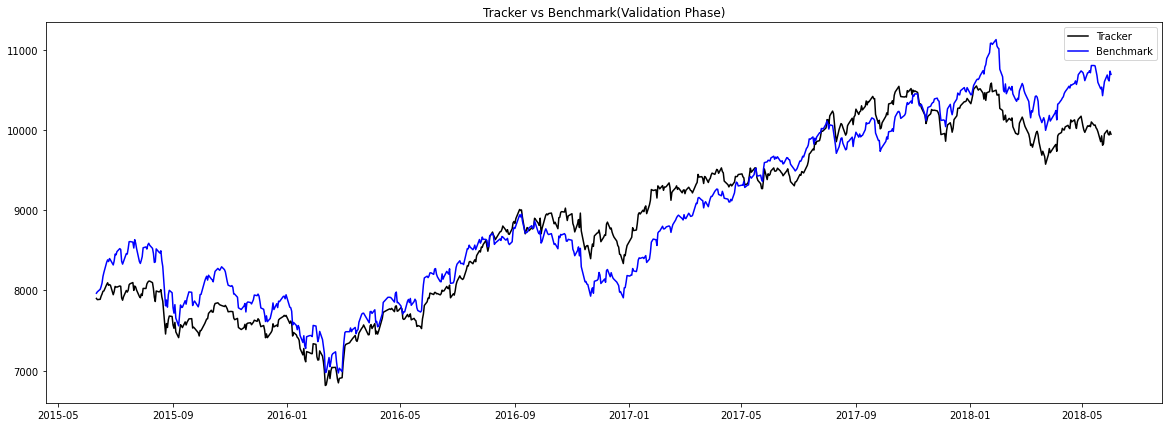

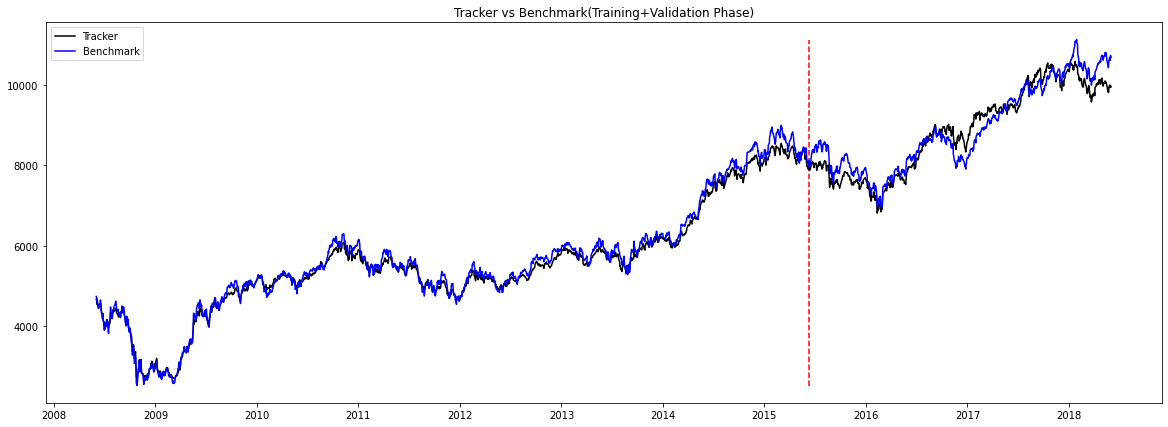

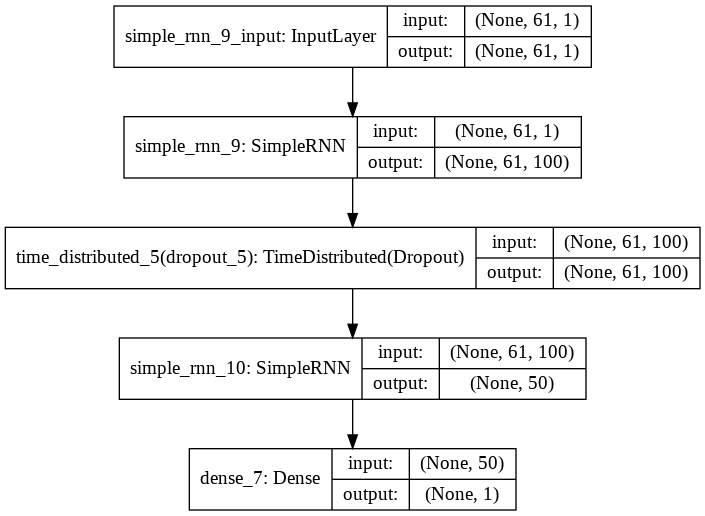

In [ ]:
#plot_tracker(df, model, test_predict, Y_test, predicted)
#plot_model(model,show_shapes=True)

Now that the model has been built, we verify it's efficacy in the validation set by ploting both the benchmark as well as the tracker values

Now that I have obtained my predicted time series, I intend to use one of the similarity measures proposed by Mori et al. with their respctive implementation in the **TSDist** library in R.   

In [ ]:
'''
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

base=importr('base')
stats=importr('stats')
ro.r('install.packages("TSdist")')
TSDist=importr('TSdist')
predicted=np.reshape(predicted,(predicted.shape[0],))
p=pd.Series(predicted,copy=True)
tracker=base.as_numeric(predicted.tolist())
benchmark=base.as_numeric(df["Price_51"].tolist())
dist=TSDist.CCorDistance(tracker, benchmark)
dist
'''

0.004489


In [ ]:
'''
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

def LSTM_AutoEnc_2(Data,compression):
    
    model = Sequential()
    model.add(SimpleRNN(100, activation='relu', input_shape=(Data.shape[1],Data.shape[2]),return_sequences=True,name='Enc_1'))
    model.add(SimpleRNN(20, activation='relu', return_sequences=False,name='Enc_1_1'))
    model.add(RepeatVector(Data.shape[1]))
    model.add(SimpleRNN(Data.shape[2], activation='relu', return_sequences=True,name='Dec_1'))
    model.add(TimeDistributed(Dense(Data.shape[2],kernel_regularizer='l2'),name='dec_1'))
    model.compile(optimizer='rmsprop', loss='mse')

    hist=model.fit(Data,Data,epochs=1000,batch_size=20,callbacks=[EarlyStopping(monitor='loss',patience=20,restore_best_weights=True)],shuffle=False)

    model=Model(inputs=model.inputs, outputs=model.layers[4].output)
    decoded_data=model.predict(Data)
    decoded_data.shape     
'''